## Задание на практику в Jet Brains

In [1]:
# функции для обработки всего этого добра, вынес отдельно, чтобы не загромождали ноутбук
from utils import (
    unflatten,
    tag_to_list,
    title_to_list,
    body_to_list,
    extract_by_function,
    extract_phrases,
    draw_popular,
    draw_cloud,
)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

from matplotlib.pyplot import figure


import warnings

warnings.filterwarnings("ignore")

Сделаем запрос: в [StackOverflow Query](https://data.stackexchange.com/stackoverflow/query/new) - начиная с какой-то даты. 
    
```
SELECT Id, Title, Body, Tags, creationDate 
FROM Posts
where creationDate > '2022-02-01' 
ORDER BY creationDate ASC;
```

Но этот сервис возвращает только 50000 строк (это примерно 4-5 дня). 

Можно или монотонно выкачать все данные за пол года. (Или попробовать сделать похожую штуку в API, а не запросом).

Но пока выкачаю только за февраль:
- начну с первого февраля
- сортирую по creationDate ASC, чтобы сразу видеть какой датой закончился первый запрос, и запросить следующий (и чтобы не упустить никакие запросы).
- всего получилось 7 запросов (7 файлов) - выкачал по отдельности и смержу:
    * `creationDate > '2022-02-01'`
    * `creationDate > '2022-02-05'`
    * `creationDate > '2022-02-09'`
    * `creationDate > '2022-02-13'`
    * `creationDate > '2022-02-17'`
    * `creationDate > '2022-02-21'`
    * `creationDate > '2022-02-25'`
- некоторые айдишники могут пересекаться, так как респонс от сервера обрезается ровно на 50к запросах, а не на дате - надо будет при мерже удалить дубликаты. 

## Чтение и мерж датасетов

In [2]:
datas = []
for i in range(7):
    datas.append(pd.read_csv('data/QueryResults ({}).csv'.format(i)))

In [3]:
data = pd.concat(datas).drop_duplicates(subset=['Id'], keep='first')
data

,Id,Title,Body,Tags,creationDate
0,70934245,NaN,<p>I think I'll go with MQTT's shared subcript...,NaN,2022-02-01 00:00:11
1,70934248,NaN,<p>Your example data:</p>\n<pre><code>df &lt;-...,NaN,2022-02-01 00:00:35
2,70934247,debugging the code How do I search for an maca...,<p>mac=\n00-FF-2E-3B-D1-0B</p>\n<p>00-FF-70-6B...,<python><python-3.x><list><python-2.7><mac-add...,2022-02-01 00:00:39
3,70934250,All self-hosted agents cannot connect to devop...,<p>All of our self-hosted agents cannot connec...,<azure-devops>,2022-02-01 00:01:00
4,70934251,NextJs not displaying data from API calls afte...,<p>I got a nextJS app deployed to vercel but I...,<ruby-on-rails><next.js><vercel>,2022-02-01 00:01:05
...,...,...,...,...,...
49549,71259590,NaN,"<p>import 'dart:math';\nstring.substring(0, mi...",NaN,2022-02-24 23:59:08
49550,71259593,NaN,<p>I think you are trying to do something like...,NaN,2022-02-24 23:59:15
49551,71259594,"With Singer taps and targets, why are columns ...","<p>When using singer taps and targets, we some...",<singer-io><meltano>,2022-02-24 23:59:43
49552,71259595,NaN,<h2>A little background info</h2>\n<p>By way o...,NaN,2022-02-24 23:59:43


## Для процессинга слов

In [4]:
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
BAD_WORDS = ['=', '{', '},', '}', '/', '//', '...', '..', '.',',', '});', '<script', '<input', '/>', '-', '<', ':','[', ']','(', ')', '--', '{', '}','/*', '*/', '<a', '"', '<div', '</div>', ' ', '  ', '   ', '=>', '<button', '0;', 'var', '</td', '', 'background-color:', 'false;', '0', '1', '30', '31', 'math.pi', '--info', '--debug', 'O', '2']

## Работа с Тегами
Будем использовать стандартный пайплайн:
- токенизация
- удаление стоп-слов

In [5]:
grouped_tags, tags = extract_by_function(data.Tags, tag_to_list)
tags = [w for w in tags if not w in stop_words]
# tags_stems = [porter.stem(t) for t in tags]

Я не буду стеммить теги, люди и так пишут в "стемминговой" форме, а стемминг только ухудшает читаемость выводы: например, `ios` становится `io` - разные понятия.

Different tags: 23271


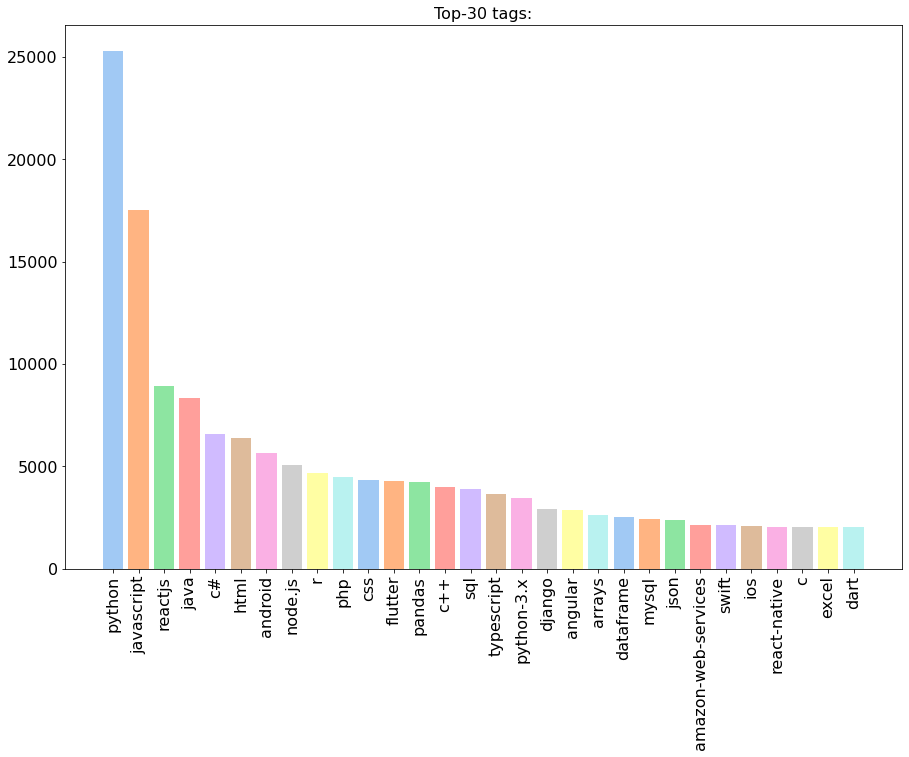

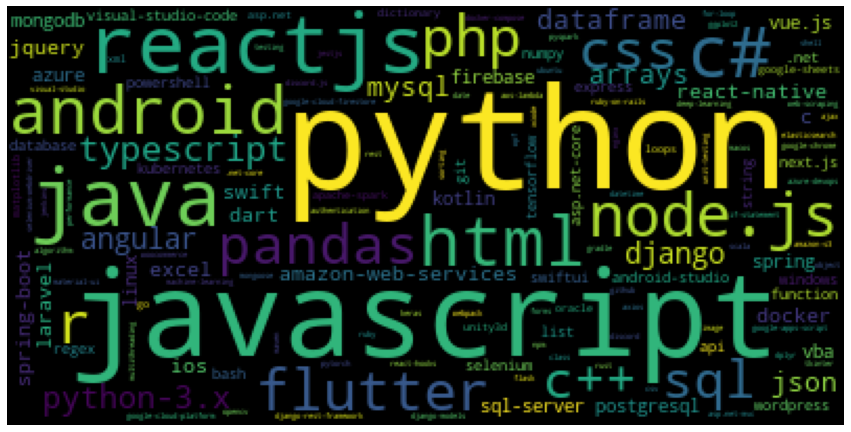

<Figure size 18000x10500 with 0 Axes>

In [6]:
tags_freq = draw_popular(tags, n=30)
draw_cloud(tags_freq)

## Обработка названий тредов

Тот же пайплайн, но здесь мы будем использовать стемминг (поэтому некоторые слова звучат немного странно).

In [7]:
grouped_title_words, title_words = extract_by_function(data.Title, title_to_list)
title_words = [w for w in title_words if not w in stop_words]
title_words_stems = [porter.stem(t) for t in title_words]

Different tags: 93610


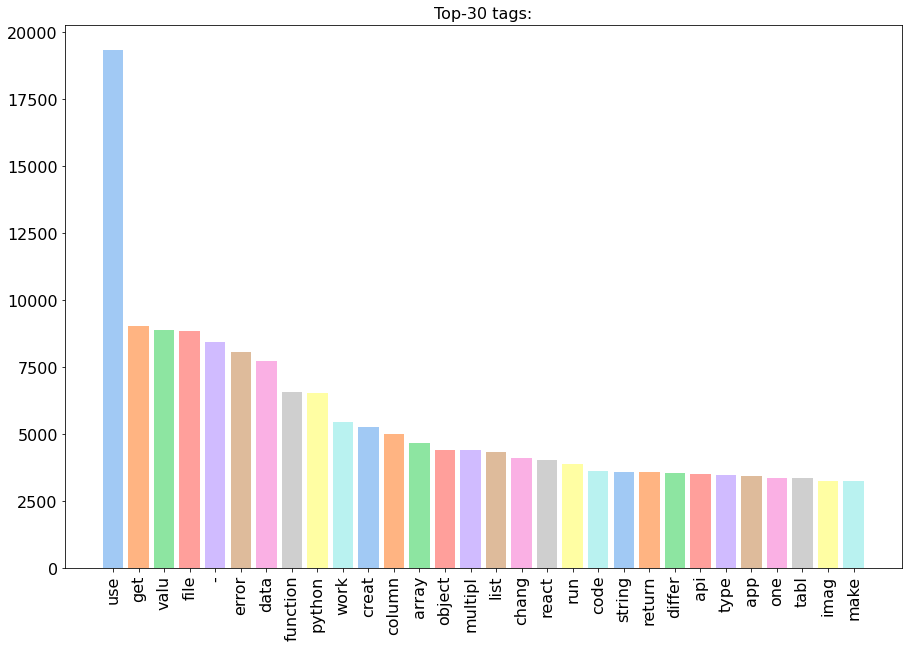

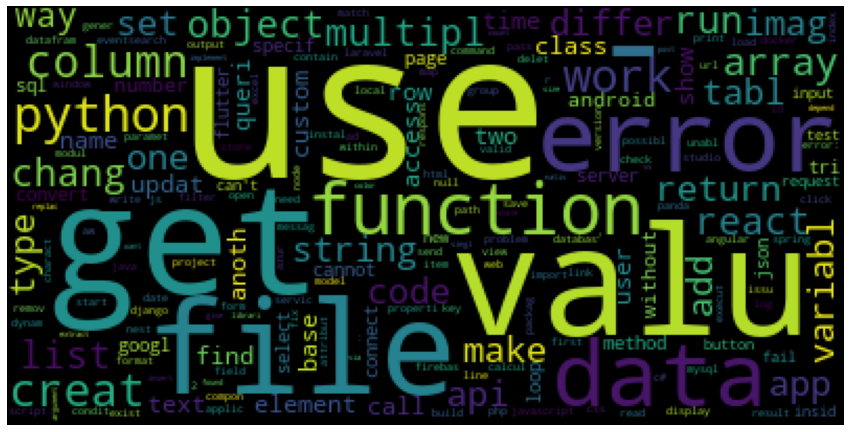

<Figure size 18000x10500 with 0 Axes>

In [8]:
titles_freq = draw_popular(title_words_stems, n=30)
draw_cloud(titles_freq)

### Фразы в названии

Посмотрим на пары слов.

Different tags: 505900


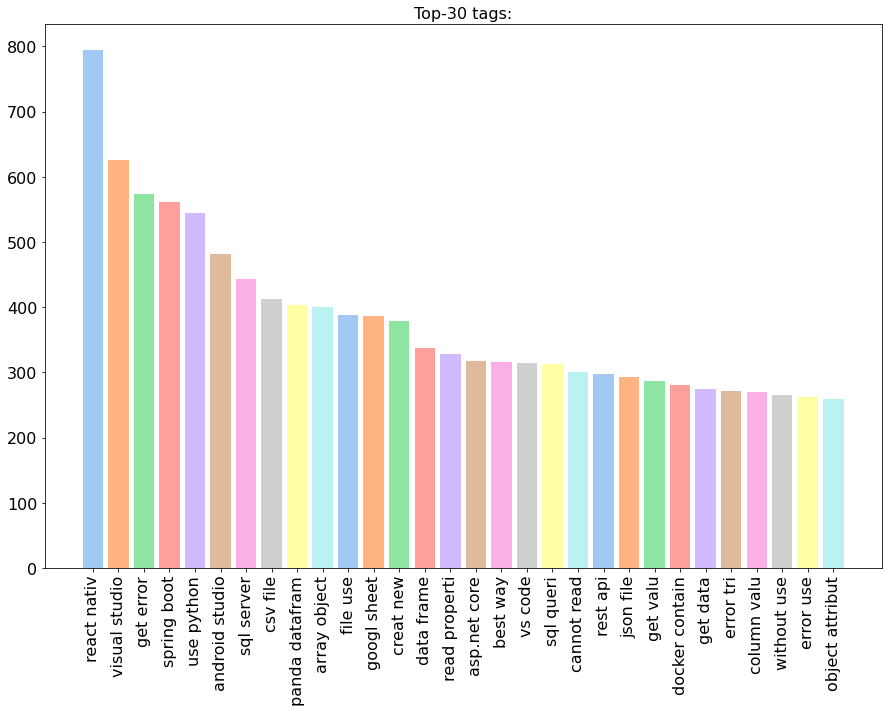

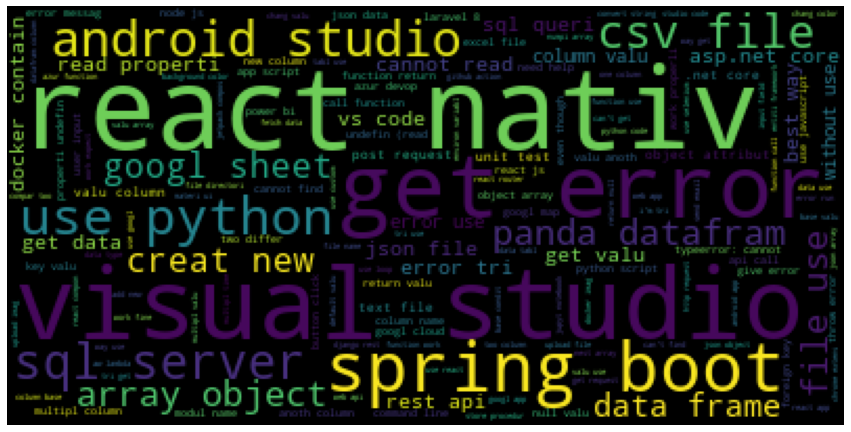

<Figure size 18000x10500 with 0 Axes>

In [9]:
title_phrases2 = extract_phrases(data.Title, title_to_list, k=2)
draw_cloud(draw_popular(title_phrases2, n=30))

И тройки

Different tags: 671223


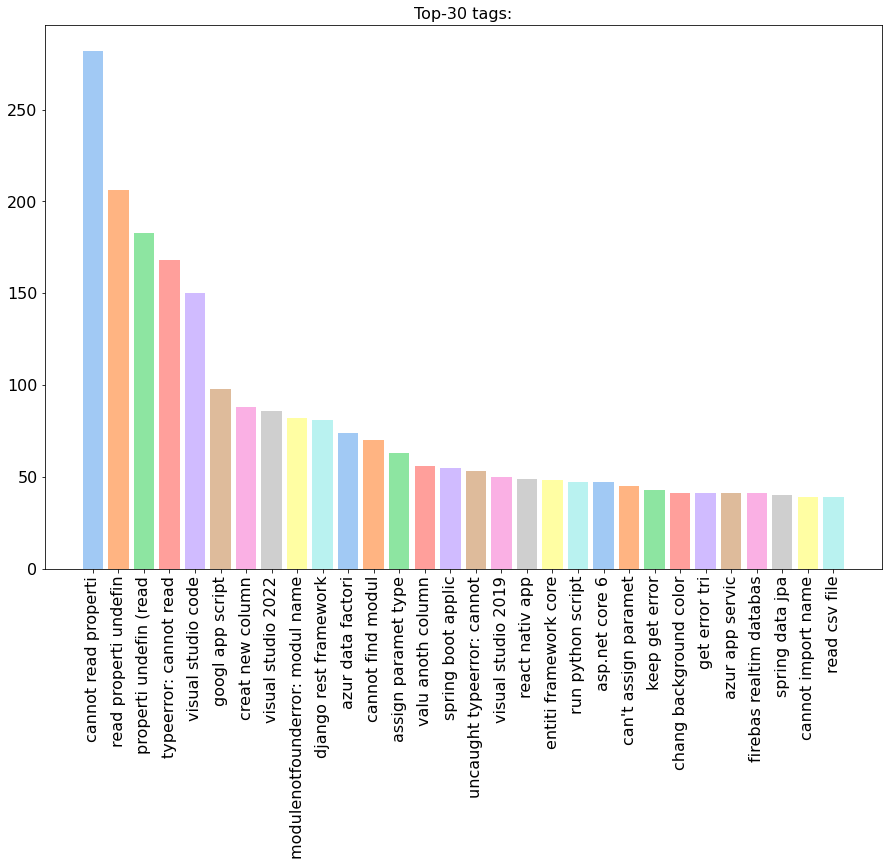

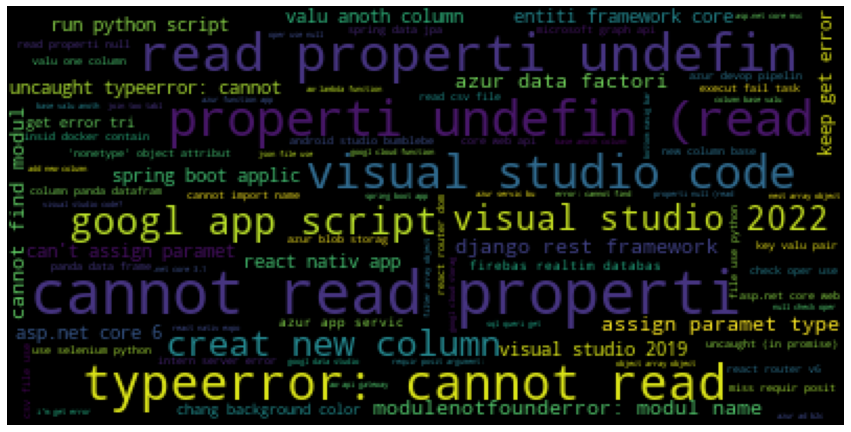

<Figure size 18000x10500 with 0 Axes>

In [10]:
title_phrases3 = extract_phrases(data.Title, title_to_list, k=3)
draw_cloud(draw_popular(title_phrases3, n=30))

И четверки

Different tags: 556922


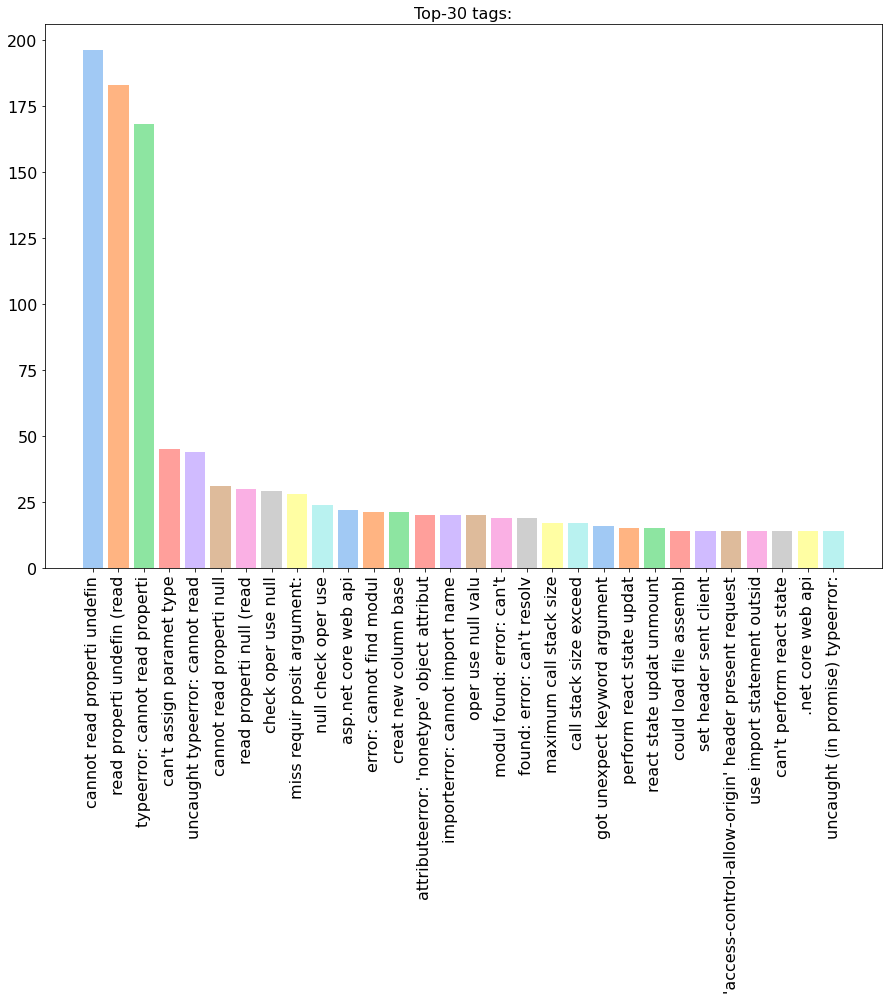

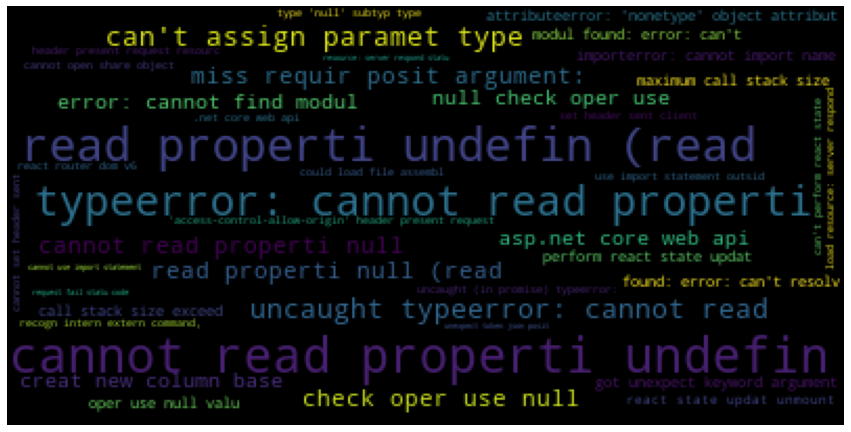

<Figure size 18000x10500 with 0 Axes>

In [11]:
title_phrases4 = extract_phrases(data.Title, title_to_list, k=4)
draw_cloud(draw_popular(title_phrases4, n=30))

## Тело треда
Примерно та же кухня, только мы еще учитываем, что в теле присутствует разметка - надо извлекать только текст (по тегам: `<p> </p>` и `<li> </li>`).

In [12]:
%%time
grouped_body, body = extract_by_function(data.Body, body_to_list)
body = [w for w in body if not w in stop_words]
body_stems = [porter.stem(t) for t in body]
body = [w for w in body_stems if not w in BAD_WORDS]

CPU times: user 5min 1s, sys: 1.83 s, total: 5min 3s
Wall time: 5min 3s


Different tags: 1018705


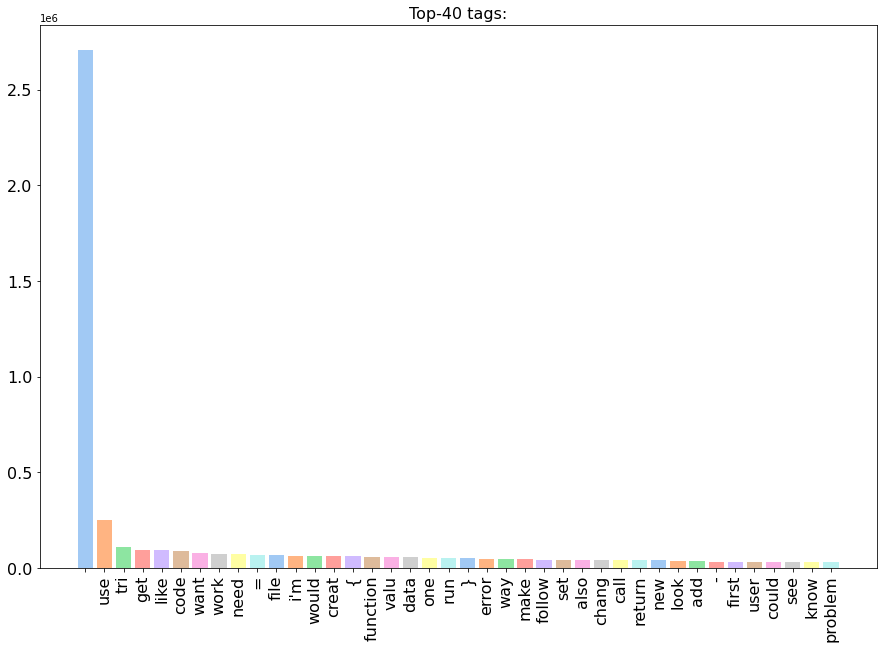

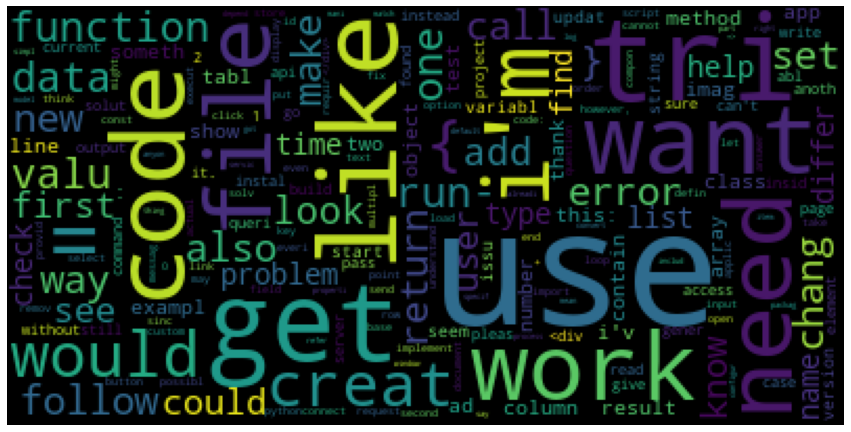

<Figure size 18000x10500 with 0 Axes>

CPU times: user 10 s, sys: 84 ms, total: 10.1 s
Wall time: 10.1 s


In [13]:
%%time
body_freq = draw_popular(body_stems, n=40)
draw_cloud(body_freq)

### Фразы в теле

Different tags: 6062796


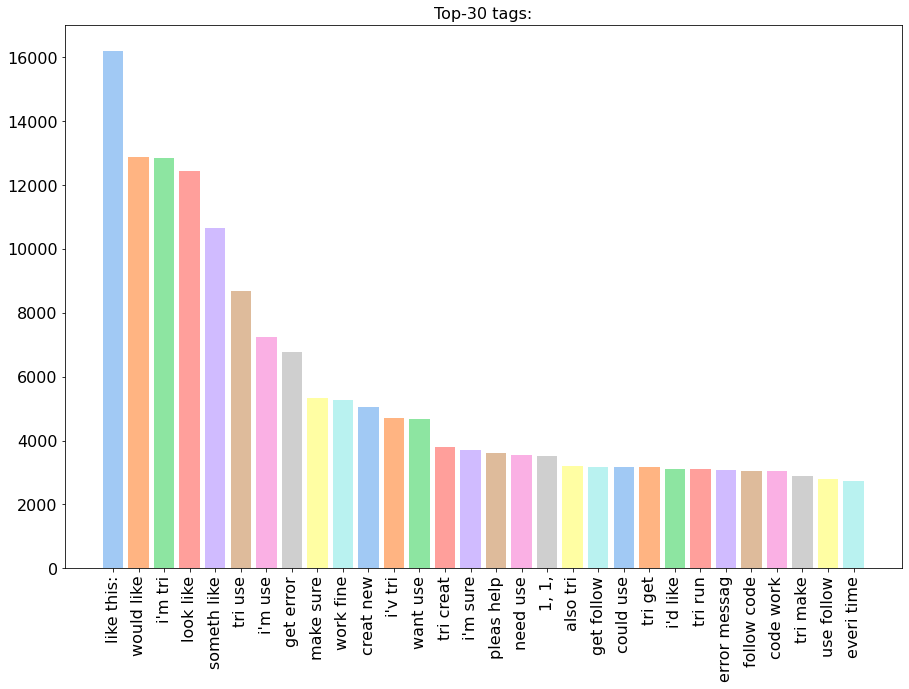

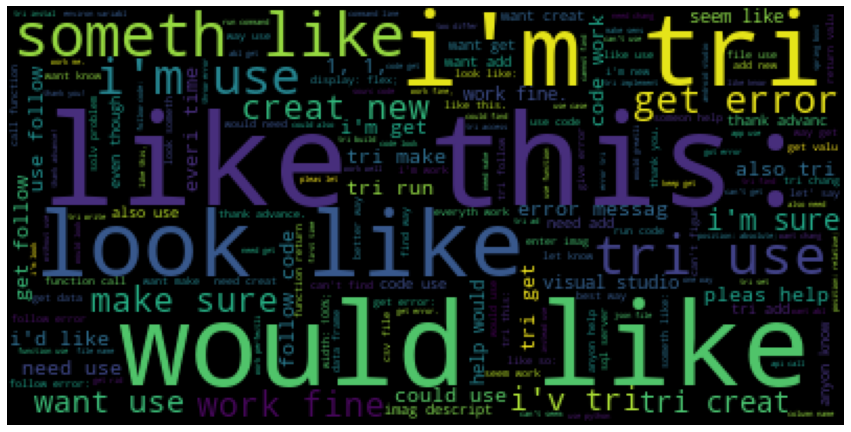

<Figure size 18000x10500 with 0 Axes>

In [14]:
body_phrases2 = extract_phrases(data.Body, body_to_list, k=2)
draw_cloud(draw_popular(body_phrases2, n=30))

Different tags: 11411061


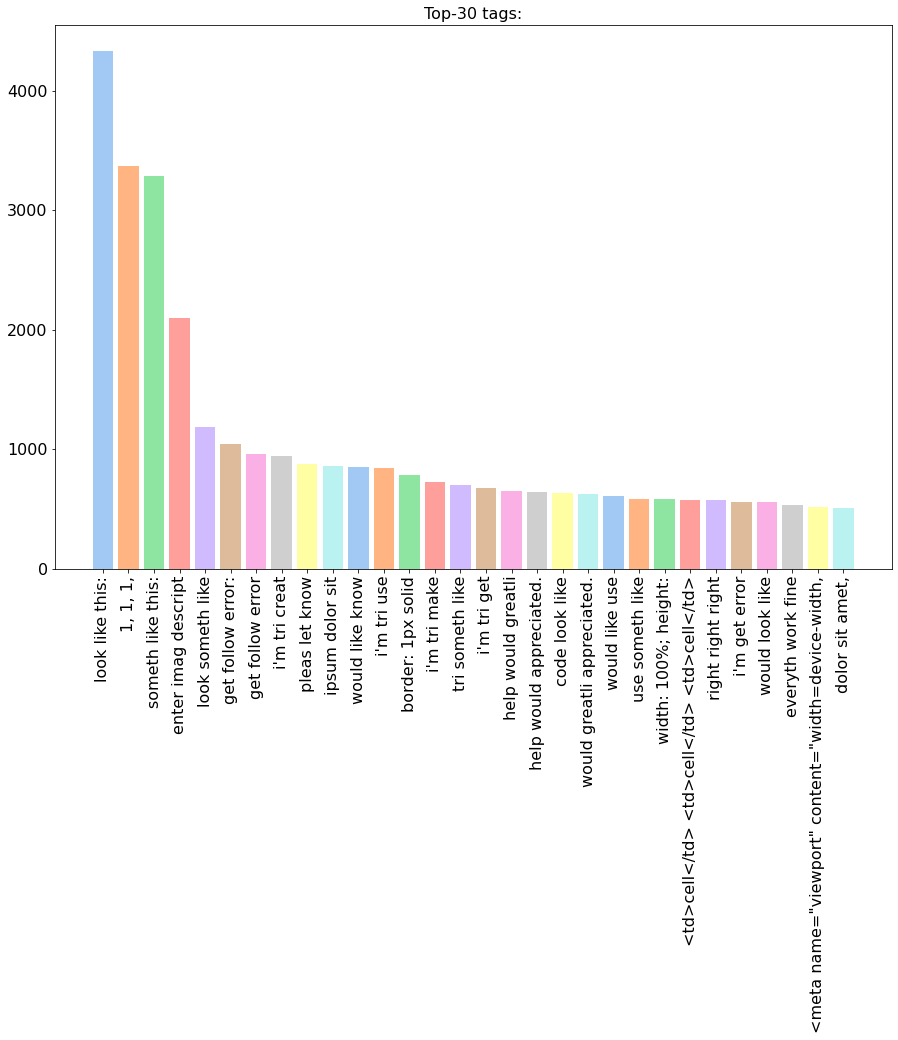

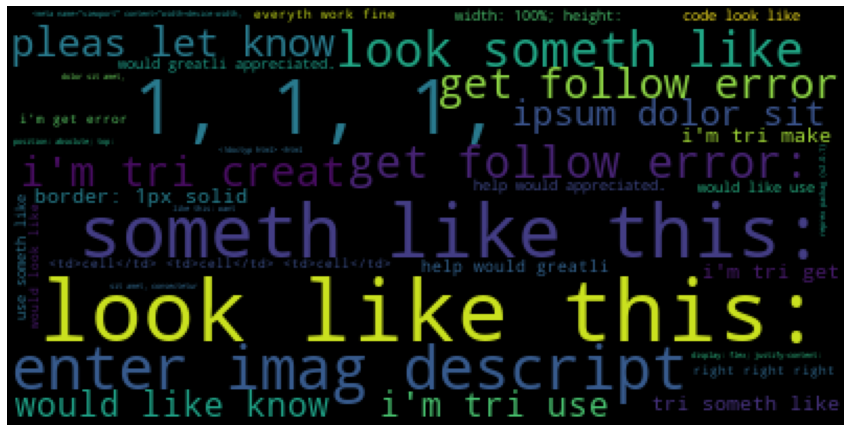

<Figure size 18000x10500 with 0 Axes>

In [15]:
body_phrases3 = extract_phrases(data.Body, body_to_list, k=3)
draw_cloud(draw_popular(body_phrases3, n=30))

Different tags: 12217219


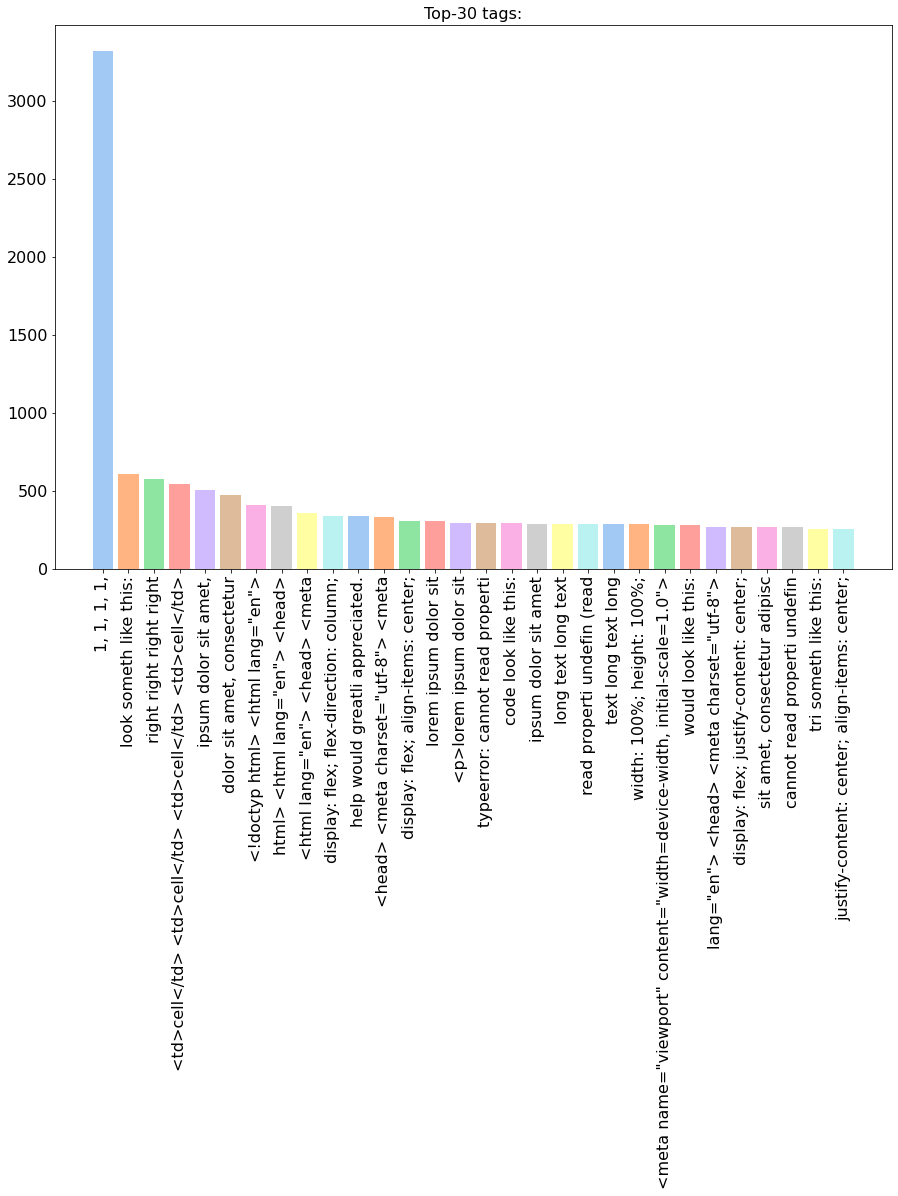

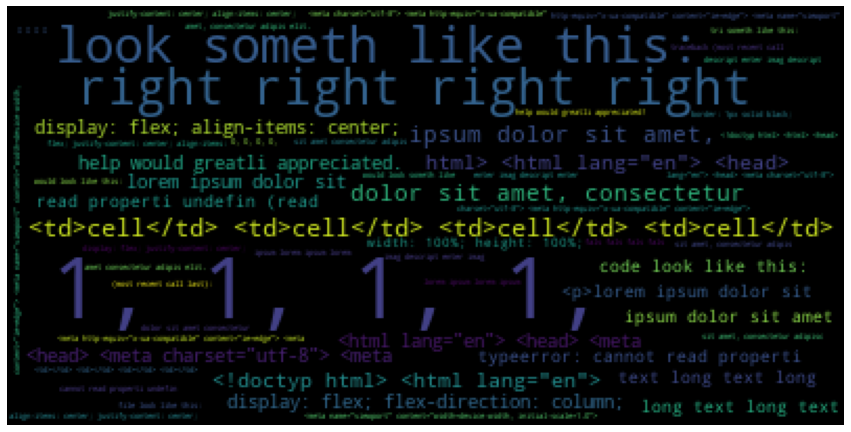

<Figure size 18000x10500 with 0 Axes>

In [16]:
body_phrases4 = extract_phrases(data.Body, body_to_list, k=4)
draw_cloud(draw_popular(body_phrases4, n=30))

К сожалению, когда я попытался сделать графики для фраз, вылезли всякие спецсимволы и разметочные теги, которые почему-то beautiful soup считает текстом (я поправил часть ручками - хардкодингом, но все равно они вылезают).

Я могу с этим разобраться, или попробовать использовать другие библиотеки или поискать стоп-слова для html. Но позже!

## Вывод

Можно нарисовать еще много графиков: делить по дате, смотреть как изменяются запросы во времени. Кроме того, можно взять бОльший временной интервал. Но суть остается та же - мы получили, что хотели.

При анализе можно заметить как слова и фразы, ориентированные на программирование (ошибки, специализированные стеки технологий и так далее), так и обычные слова: у людей вылезают ошибки, они пытаются что-то исправить, подкорректировать, и так далее. Но это уже выходит за рамки текущего тестового задания:)